# PGK2 Selectivity — Chemical Space Analysis
## Projections, PCA, t-SNE, and Tanimoto Similarity

**Workflow:**
1. Run `extract_projections.py --config <your_config>` to produce `projections.npz` + `projections_meta.csv`
2. Set `PROJECTIONS_NPZ` / `META_CSV` paths in the cell below
3. Run all cells

**Arrays in `projections.npz`**

| Key | Shape | Description |
|-----|-------|-------------|
| `ligand_repr` | (N, 256) | Pre-FiLM ligand encoding — pure chemistry, pocket-blind |
| `metric_emb` | (N, 64) | L2-normalized metric-learning space (if model has metric head) |
| `post_film_pgk1` | (N, 256) | FiLM-modulated repr conditioned on PGK1 pocket |
| `post_film_pgk2` | (N, 256) | FiLM-modulated repr conditioned on PGK2 pocket |
| `morgan_fp` | (N, 2048) | ECFP4 fingerprint for Tanimoto similarity |
| `p_bind_pgk1` | (N,) | Model P(bind \| PGK1) |
| `p_bind_pgk2` | (N,) | Model P(bind \| PGK2) |
| `selectivity` | (N,) | p_bind_pgk2 − p_bind_pgk1 |

## 1 · Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Scaffolds import MurckoScaffold

# Optional — suppress noisy warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
print("Imports OK")

Imports OK


## 2 · Load and Prepare Screening Data

In [3]:
# ── CONFIGURE PATHS HERE ─────────────────────────────────────────────────────
PROJECTIONS_NPZ = "data/enamine/screening_v1/projections.npz"
META_CSV        = "data/enamine/screening_v1/projections_meta.csv"
# ─────────────────────────────────────────────────────────────────────────────

# Load arrays
data = np.load(PROJECTIONS_NPZ, allow_pickle=True)
print("Arrays in file:")
for k in data.files:
    v = data[k]
    print(f"  {k:20s}  shape={v.shape}  dtype={v.dtype}")

# Load metadata
df = pd.read_csv(META_CSV, index_col=0)
print(f"\nMetadata: {len(df):,} compounds")
df.head()

Arrays in file:
  smiles                shape=(19210,)  dtype=<U68
  ligand_repr           shape=(19210, 256)  dtype=float32
  post_film_pgk1        shape=(19210, 256)  dtype=float32
  post_film_pgk2        shape=(19210, 256)  dtype=float32
  morgan_fp             shape=(19210, 2048)  dtype=uint8
  p_bind_pgk1           shape=(19210,)  dtype=float32
  p_bind_pgk2           shape=(19210,)  dtype=float32
  selectivity           shape=(19210,)  dtype=float32
  metric_emb            shape=(19210, 64)  dtype=float32

Metadata: 19,210 compounds


,smiles,p_bind_pgk1,p_bind_pgk2,selectivity
0,COc1ccc(Nc2ncnc3sccc23)c(OC)c1,0.035245,0.636798,0.601553
1,COc1ccc(NC(C)=O)cc1Nc1ncnc2sc(C)c(C)c12,0.061242,0.676635,0.615394
2,CSC1(C(=O)NC2CCN(c3ncccn3)CC2)CCC1,0.062769,0.578107,0.515338
3,Cc1cc(C(C)Nc2ncnc3ccncc23)c(C)s1,0.085639,0.630416,0.544776
4,CSc1cc(C(=O)Nc2cnccn2)ccc1F,0.193452,0.842775,0.649323


In [4]:
# Unpack key arrays
smiles         = data['smiles'].tolist()
ligand_repr    = data['ligand_repr']      # (N, 256)
morgan_fp      = data['morgan_fp']        # (N, 2048)
p_bind_pgk1    = data['p_bind_pgk1']
p_bind_pgk2    = data['p_bind_pgk2']
selectivity    = data['selectivity']      # pgk2 - pgk1

has_metric = 'metric_emb' in data.files
if has_metric:
    metric_emb = data['metric_emb']       # (N, 64)
    print(f"✓ metric_emb shape: {metric_emb.shape}")
else:
    print("⚠ No metric_emb (model was trained without metric head) — using ligand_repr for analysis")
    metric_emb = ligand_repr

# Has post-film per pocket?
has_post_film = 'post_film_pgk2' in data.files

# Define selectivity labels
THRESH_PGK2   = 0.0   # score > +0.1 → strong PGK2-selective
THRESH_PGK1   = -0.0  # score < -0.1 → strong PGK1-selective

labels = np.where(selectivity >  THRESH_PGK2, 'PGK2-selective',
         np.where(selectivity <  THRESH_PGK1, 'PGK1-selective', 'Neutral'))

color_map = {'PGK2-selective': '#2ecc71', 'PGK1-selective': '#e74c3c', 'Neutral': '#bdc3c7'}
colors    = [color_map[l] for l in labels]

for lab in np.unique(labels):
    n = (labels == lab).sum()
    print(f"  {lab:20s}: {n:6,}  ({100*n/len(labels):.1f}%)")

✓ metric_emb shape: (19210, 64)
  Neutral             :      1  (0.0%)
  PGK1-selective      :  6,586  (34.3%)
  PGK2-selective      : 12,623  (65.7%)


## 3 · Extract Frozen Metric Learning Projections

The arrays in `projections.npz` are already extracted by `extract_projections.py`.  
This section summarises the spaces and picks the best one for downstream analysis.

| Space | Dim | When to use |
|---|---|---|
| `metric_emb` | 64 | **Primary** — trained to separate selective from non-selective |
| `ligand_repr` | 256 | Fallback if no metric head; raw chemistry encoding |
| `post_film_pgk2` | 256 | Joint (pocket + ligand) view — useful for PGK2-pocket interactions |
| `morgan_fp` | 2048 | Classical Tanimoto similarity; independent of model |

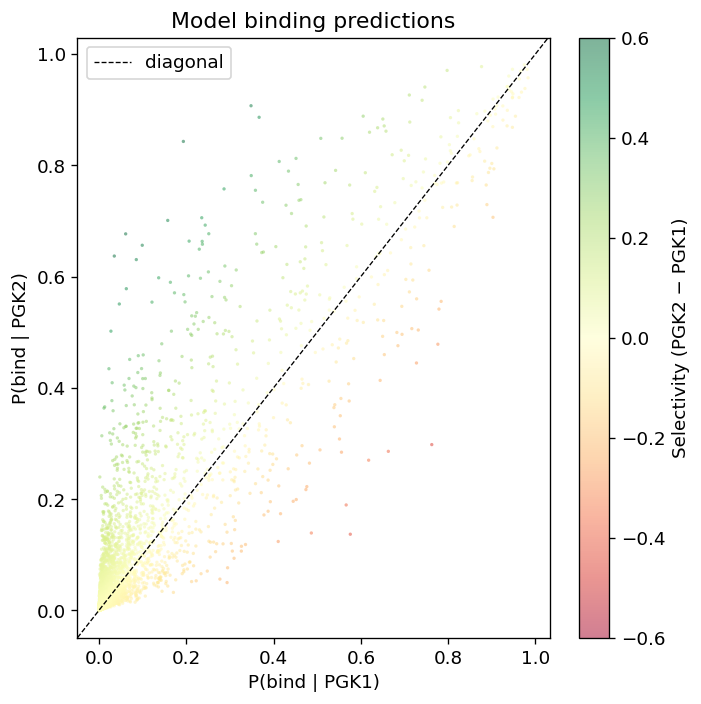

Selectivity range: [-0.464, 0.649]
Mean ± std:         0.006 ± 0.040


In [5]:
# p_bind PGK1 vs PGK2 scatter — raw model output
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(p_bind_pgk1, p_bind_pgk2,
                c=selectivity, cmap='RdYlGn',
                vmin=-0.6, vmax=0.6,
                s=4, alpha=0.5, linewidths=0)
plt.colorbar(sc, ax=ax, label='Selectivity (PGK2 − PGK1)')
ax.axline((0, 0), slope=1, color='k', lw=0.8, ls='--', label='diagonal')
ax.set_xlabel('P(bind | PGK1)')
ax.set_ylabel('P(bind | PGK2)')
ax.set_title('Model binding predictions')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Selectivity range: [{selectivity.min():.3f}, {selectivity.max():.3f}]")
print(f"Mean ± std:         {selectivity.mean():.3f} ± {selectivity.std():.3f}")

## 4 · Dimensionality Reduction with PCA

PCA on the metric learning embedding (`metric_emb`, 64-dim).  
Because the metric head produces L2-normalized vectors, **do not StandardScale** — the norms are already meaningful.

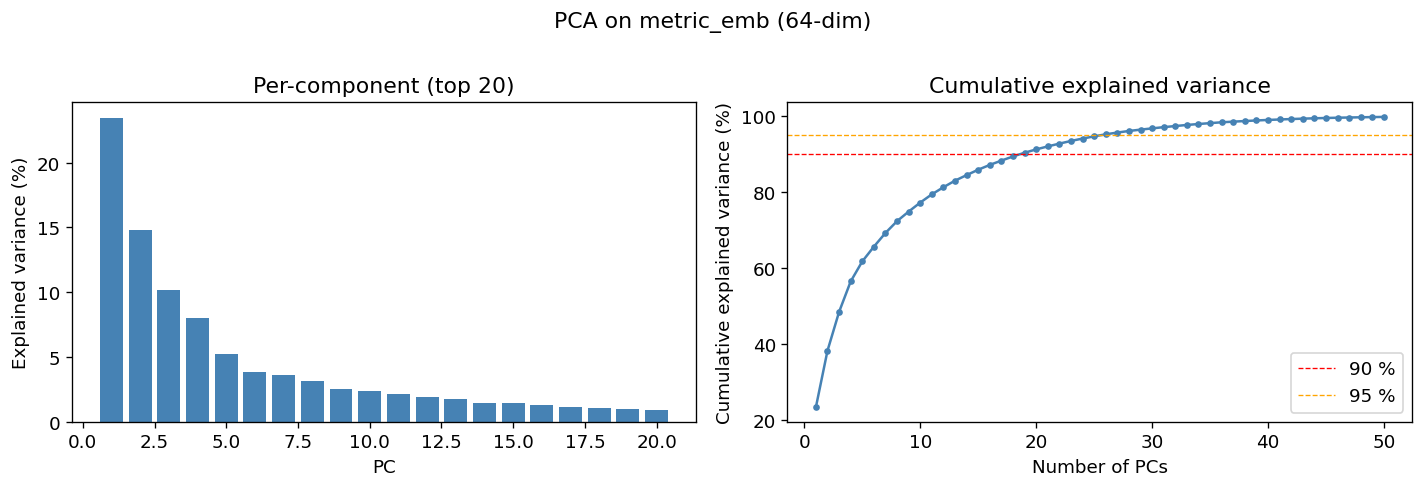

PCs to explain 90% variance: 19
PCs to explain 95% variance: 26


In [12]:
pca = PCA(n_components=min(50, metric_emb.shape[1]))
pca.fit(metric_emb)

# Explained variance plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.bar(range(1, 21), pca.explained_variance_ratio_[:20] * 100, color='steelblue')
ax.set_xlabel('PC'); ax.set_ylabel('Explained variance (%)')
ax.set_title('Per-component (top 20)')

ax = axes[1]
cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
ax.plot(range(1, len(cumvar) + 1), cumvar, 'o-', ms=3, color='steelblue')
ax.axhline(90, color='r', ls='--', lw=0.8, label='90 %')
ax.axhline(95, color='orange', ls='--', lw=0.8, label='95 %')
ax.set_xlabel('Number of PCs'); ax.set_ylabel('Cumulative explained variance (%)')
ax.set_title('Cumulative explained variance')
ax.legend()

plt.suptitle('PCA on metric_emb (64-dim)', y=1.01)
plt.tight_layout()
plt.show()

n90 = np.searchsorted(cumvar, 90) + 1
n95 = np.searchsorted(cumvar, 95) + 1
print(f"PCs to explain 90% variance: {n90}")
print(f"PCs to explain 95% variance: {n95}")

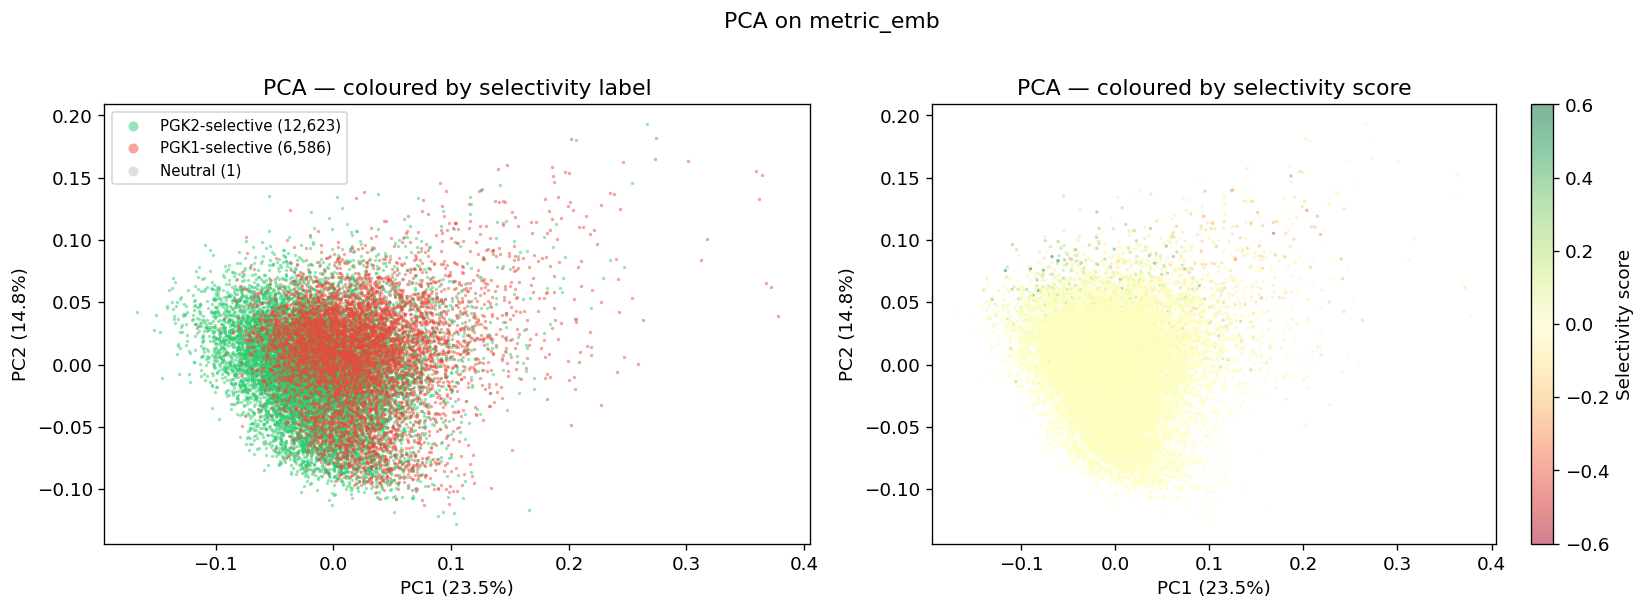

In [13]:
pca2 = PCA(n_components=2)
Z_pca = pca2.fit_transform(metric_emb)   # (N, 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: coloured by discrete label
ax = axes[0]
for lab, col in color_map.items():
    mask = labels == lab
    ax.scatter(Z_pca[mask, 0], Z_pca[mask, 1],
               c=col, s=4, alpha=0.5, linewidths=0, label=f'{lab} ({mask.sum():,})')
ax.set_xlabel(f'PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA — coloured by selectivity label')
ax.legend(markerscale=3, fontsize=9)

# Right: coloured by continuous selectivity score
ax = axes[1]
sc = ax.scatter(Z_pca[:, 0], Z_pca[:, 1],
                c=selectivity, cmap='RdYlGn',
                vmin=-0.6, vmax=0.6,
                s=4, alpha=0.5, linewidths=0)
plt.colorbar(sc, ax=ax, label='Selectivity score')
ax.set_xlabel(f'PC1 ({pca2.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca2.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA — coloured by selectivity score')

plt.suptitle('PCA on metric_emb', y=1.01)
plt.tight_layout()
plt.show()

## 5 · Visualization with t-SNE

t-SNE is run on the PCA-reduced space (top `n_pca_for_tsne` components) for speed and to remove noise.  
For large libraries (>50 k compounds) consider sub-sampling.

In [14]:
# ── t-SNE settings (tune as needed) ──────────────────────────────────────────
N_MAX_TSNE       = 20_000   # sub-sample for speed; set None to use all
N_PCA_FOR_TSNE   = 20       # pre-reduce with PCA before t-SNE
PERPLEXITY       = 40
LEARNING_RATE    = 200
N_ITER           = 1000
RANDOM_STATE     = 42
# ─────────────────────────────────────────────────────────────────────────────

N = len(metric_emb)
if N_MAX_TSNE and N > N_MAX_TSNE:
    rng = np.random.default_rng(RANDOM_STATE)
    idx_tsne = rng.choice(N, N_MAX_TSNE, replace=False)
    idx_tsne.sort()
    print(f"Sub-sampling {N_MAX_TSNE:,} / {N:,} compounds for t-SNE")
else:
    idx_tsne = np.arange(N)

# Pre-reduce
Z_pre = PCA(n_components=N_PCA_FOR_TSNE).fit_transform(metric_emb[idx_tsne])

print(f"Running t-SNE (perplexity={PERPLEXITY}, lr={LEARNING_RATE}, n_iter={N_ITER})...")
tsne = TSNE(n_components=2, perplexity=PERPLEXITY,
            learning_rate=LEARNING_RATE,
            random_state=RANDOM_STATE, n_jobs=-1)
Z_tsne = tsne.fit_transform(Z_pre)
print(f"✓ t-SNE done  shape={Z_tsne.shape}")

Running t-SNE (perplexity=40, lr=200, n_iter=1000)...
✓ t-SNE done  shape=(19210, 2)


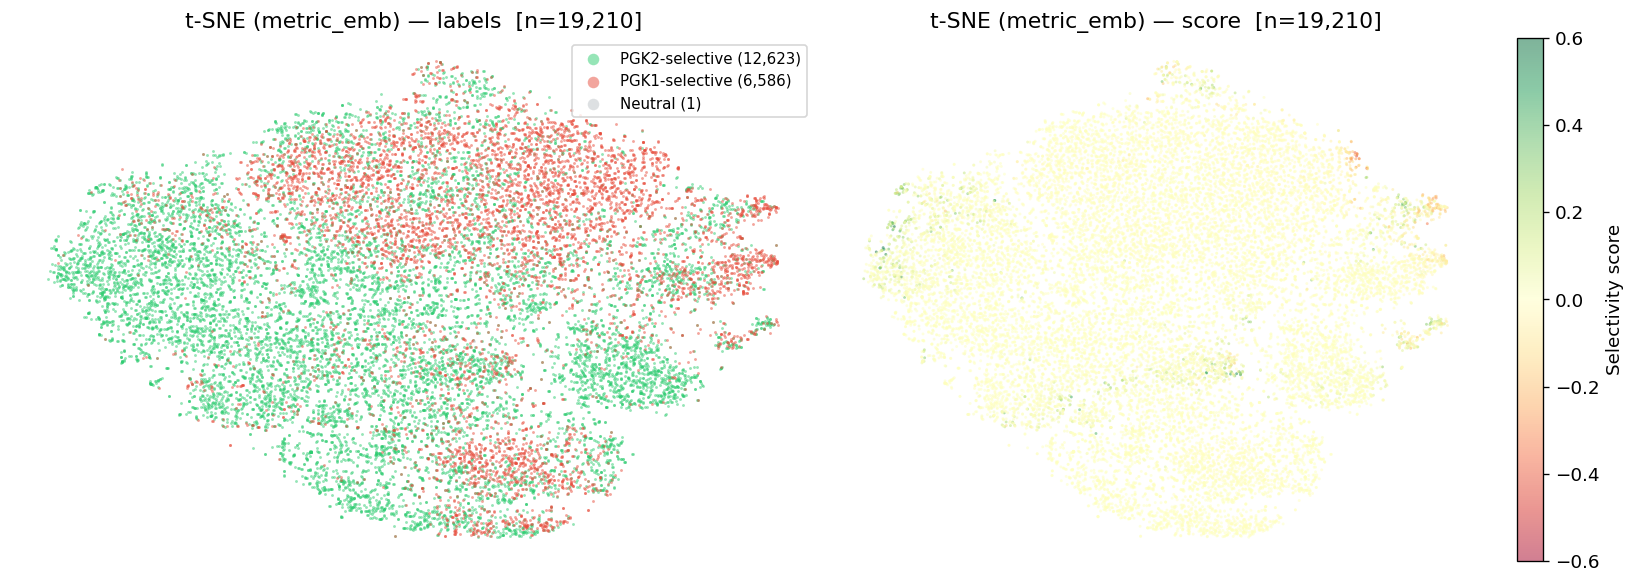

In [15]:
sel_sub   = selectivity[idx_tsne]
labels_sub = labels[idx_tsne]
colors_sub = [color_map[l] for l in labels_sub]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Discrete labels
ax = axes[0]
for lab, col in color_map.items():
    mask = labels_sub == lab
    ax.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1],
               c=col, s=3, alpha=0.5, linewidths=0, label=f'{lab} ({mask.sum():,})')
ax.set_title(f't-SNE (metric_emb) — labels  [n={len(idx_tsne):,}]')
ax.axis('off')
ax.legend(markerscale=4, fontsize=9, loc='upper right')

# Continuous score
ax = axes[1]
sc = ax.scatter(Z_tsne[:, 0], Z_tsne[:, 1],
                c=sel_sub, cmap='RdYlGn',
                vmin=-0.6, vmax=0.6,
                s=3, alpha=0.5, linewidths=0)
plt.colorbar(sc, ax=ax, label='Selectivity score')
ax.set_title(f't-SNE (metric_emb) — score  [n={len(idx_tsne):,}]')
ax.axis('off')

plt.tight_layout()
plt.show()

## 6 · Tanimoto Similarity Analysis

Tanimoto similarity is computed from ECFP4 fingerprints (stored in `morgan_fp`).  
We compare the **top PGK2-selective** compounds against each other and against a reference set.

In [7]:
def morgan_fp_to_rdkit(arr):
    """Convert uint8 numpy bit-array back to RDKit ExplicitBitVect."""
    fp = DataStructs.ExplicitBitVect(len(arr))
    for i, bit in enumerate(arr):
        if bit:
            fp.SetBit(i)
    return fp


def pairwise_tanimoto(fps):
    """Compute (n, n) Tanimoto similarity matrix from list of RDKit bit vects."""
    n = len(fps)
    sim = np.zeros((n, n), dtype=np.float32)
    for i in range(n):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
        sim[i] = sims
    return sim


# ── Select top PGK2-selective compounds ──────────────────────────────────────
TOP_N_TANIMOTO = 100   # increase for a larger heatmap (gets slow for >500)

top_pgk2_idx   = np.argsort(selectivity)[::-1][:TOP_N_TANIMOTO]
top_pgk2_smi   = [smiles[i] for i in top_pgk2_idx]
top_pgk2_sel   = selectivity[top_pgk2_idx]
top_pgk2_fp    = morgan_fp[top_pgk2_idx]

rdkit_fps = [morgan_fp_to_rdkit(fp) for fp in top_pgk2_fp]
sim_matrix = pairwise_tanimoto(rdkit_fps)

print(f"Tanimoto matrix shape: {sim_matrix.shape}")
print(f"Mean intra-set Tanimoto (off-diagonal): {sim_matrix[np.triu_indices(TOP_N_TANIMOTO, k=1)].mean():.3f}")
print(f"Max: {sim_matrix[np.triu_indices(TOP_N_TANIMOTO, k=1)].max():.3f}")

Tanimoto matrix shape: (100, 100)
Mean intra-set Tanimoto (off-diagonal): 0.151
Max: 0.750


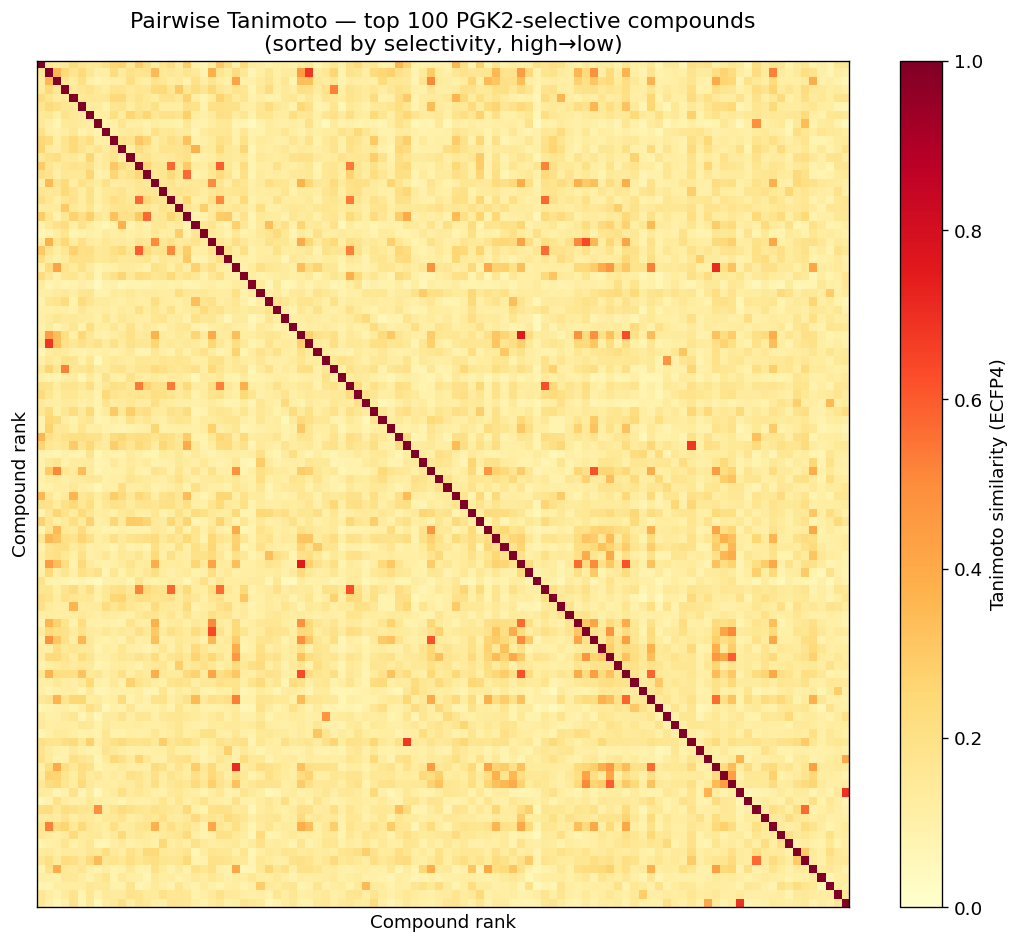

In [8]:
# Tanimoto heatmap, compounds sorted by selectivity score (highest first)
sort_order = np.argsort(top_pgk2_sel)[::-1]
sim_sorted = sim_matrix[np.ix_(sort_order, sort_order)]

fig, ax = plt.subplots(figsize=(9, 8))
im = ax.imshow(sim_sorted, vmin=0, vmax=1, cmap='YlOrRd', aspect='auto')
plt.colorbar(im, ax=ax, label='Tanimoto similarity (ECFP4)')
ax.set_title(f'Pairwise Tanimoto — top {TOP_N_TANIMOTO} PGK2-selective compounds\n(sorted by selectivity, high→low)')
ax.set_xlabel('Compound rank'); ax.set_ylabel('Compound rank')
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.show()

Mean 5-NN agreement (Tanimoto vs metric space): 0.172
  (1.0 = identical neighbours, 0 = no overlap)


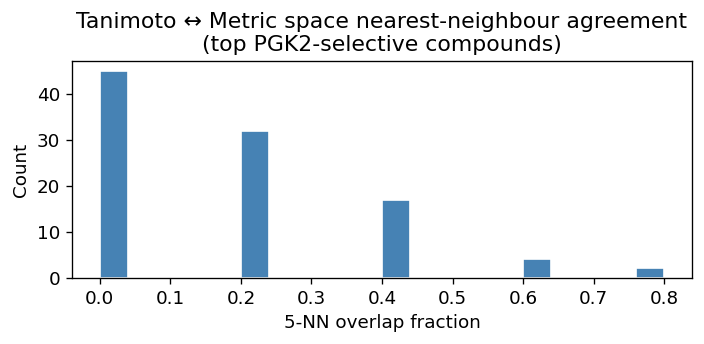

In [9]:
# Nearest-neighbor comparison: Tanimoto space vs metric_emb space
from sklearn.metrics import pairwise_distances

K = 5   # number of nearest neighbours to compare

top_metric = metric_emb[top_pgk2_idx]     # (TOP_N, 64)
metric_dist = pairwise_distances(top_metric, metric='cosine')   # cosine in L2-normalized space = angular

# For each compound: find K-NN in Tanimoto vs in metric space
nn_agree = []
for i in range(TOP_N_TANIMOTO):
    # Tanimoto NN (higher = closer → negate)
    tan_nn = set(np.argsort(-sim_matrix[i])[1:K+1])
    # Metric NN (lower distance = closer)
    met_nn = set(np.argsort(metric_dist[i])[1:K+1])
    nn_agree.append(len(tan_nn & met_nn) / K)

nn_agree = np.array(nn_agree)
print(f"Mean {K}-NN agreement (Tanimoto vs metric space): {nn_agree.mean():.3f}")
print(f"  (1.0 = identical neighbours, 0 = no overlap)")

plt.figure(figsize=(6, 3))
plt.hist(nn_agree, bins=20, color='steelblue', edgecolor='white')
plt.xlabel(f'{K}-NN overlap fraction')
plt.ylabel('Count')
plt.title('Tanimoto ↔ Metric space nearest-neighbour agreement\n(top PGK2-selective compounds)')
plt.tight_layout()
plt.show()

## 6b · Butina Clustering by Tanimoto Similarity

Butina (sphere-exclusion) clustering: a compound becomes a **cluster centre** if it is not already within `cutoff` of an existing centre.  
All compounds within `cutoff` of a centre are assigned to its cluster.  
`TANIMOTO_CUTOFF = 0.6` — compounds with Tanimoto ≥ 0.6 end up in the same cluster.

In [14]:
import numpy as np

# ── Settings ─────────────────────────────────────────────────────────────────
TANIMOTO_CUTOFF  = 0.8     # compounds with Tanimoto >= this → same cluster
CLUSTER_ON       = 'all'   # 'all' | 'pgk2' — cluster all compounds or PGK2-selective only
# ─────────────────────────────────────────────────────────────────────────────

if CLUSTER_ON == 'pgk2':
    cl_idx = np.where(labels == 'PGK2-selective')[0]
    label_str = 'PGK2-selective'
else:
    cl_idx = np.arange(len(smiles))
    label_str = 'all'

cl_smiles = [smiles[i] for i in cl_idx]
cl_fps    = morgan_fp[cl_idx]
cl_sel    = selectivity[cl_idx]
cl_labels = labels[cl_idx]

N_cl = len(cl_smiles)
print(f"Clustering {N_cl:,} {label_str} compounds (Tanimoto cutoff={TANIMOTO_CUTOFF})...")

# Build RDKit fingerprint objects
rdkit_cl_fps = [morgan_fp_to_rdkit(fp) for fp in cl_fps]

# ── Memory-efficient sphere-exclusion (Butina-equivalent) ────────────────────
# Never builds a full N×N matrix — processes one row at a time (O(N) memory).
# Algorithm:
#   1. Sort compounds by descending neighbour count (most connected first → largest cluster centre)
#   2. Greedily assign unassigned compounds: first unassigned becomes a centre;
#      all unassigned within cutoff become its members.

dist_cutoff = 1.0 - TANIMOTO_CUTOFF

# Step 1: count neighbours for each compound (to sort by connectivity)
print("  Counting neighbours...", flush=True)
neighbour_counts = np.zeros(N_cl, dtype=np.int32)
for i in range(N_cl):
    sims = np.array(DataStructs.BulkTanimotoSimilarity(rdkit_cl_fps[i], rdkit_cl_fps))
    sims[i] = 0.0   # exclude self
    neighbour_counts[i] = (sims >= TANIMOTO_CUTOFF).sum()
    if (i + 1) % 2000 == 0:
        print(f"    {i+1:,}/{N_cl:,}", flush=True)

# Step 2: sphere-exclusion in neighbour-count order
order      = np.argsort(neighbour_counts)[::-1]   # most connected first
assigned   = np.zeros(N_cl, dtype=bool)
clusters   = []   # list of lists: clusters[i][0] = centre, rest = members

print("  Assigning clusters...", flush=True)
for i in order:
    if assigned[i]:
        continue
    # i becomes a new cluster centre
    sims    = np.array(DataStructs.BulkTanimotoSimilarity(rdkit_cl_fps[i], rdkit_cl_fps))
    members = np.where((sims >= TANIMOTO_CUTOFF) & (~assigned))[0].tolist()
    # Put centre first (matches Butina convention)
    members = [i] + [m for m in members if m != i]
    clusters.append(members)
    for m in members:
        assigned[m] = True

cluster_sizes = np.array([len(c) for c in clusters])
n_clusters    = len(clusters)
n_singletons  = (cluster_sizes == 1).sum()

print(f"\n✓ Clustering complete")
print(f"  Number of clusters  : {n_clusters:,}")
print(f"  Singleton clusters  : {n_singletons:,}  ({100*n_singletons/n_clusters:.1f}% of clusters)")
print(f"  Largest cluster     : {cluster_sizes.max():,} compounds")
print(f"  Median cluster size : {np.median(cluster_sizes):.0f}")

# Assign cluster IDs back to each compound
cluster_id = np.full(N_cl, -1, dtype=int)
for cid, members in enumerate(clusters):
    for m in members:
        cluster_id[m] = cid

Clustering 19,210 all compounds (Tanimoto cutoff=0.8)...
  Counting neighbours...
    2,000/19,210
    4,000/19,210
    6,000/19,210
    8,000/19,210
    10,000/19,210
    12,000/19,210
    14,000/19,210
    16,000/19,210
    18,000/19,210
  Assigning clusters...

✓ Clustering complete
  Number of clusters  : 18,136
  Singleton clusters  : 17,356  (95.7% of clusters)
  Largest cluster     : 9 compounds
  Median cluster size : 1


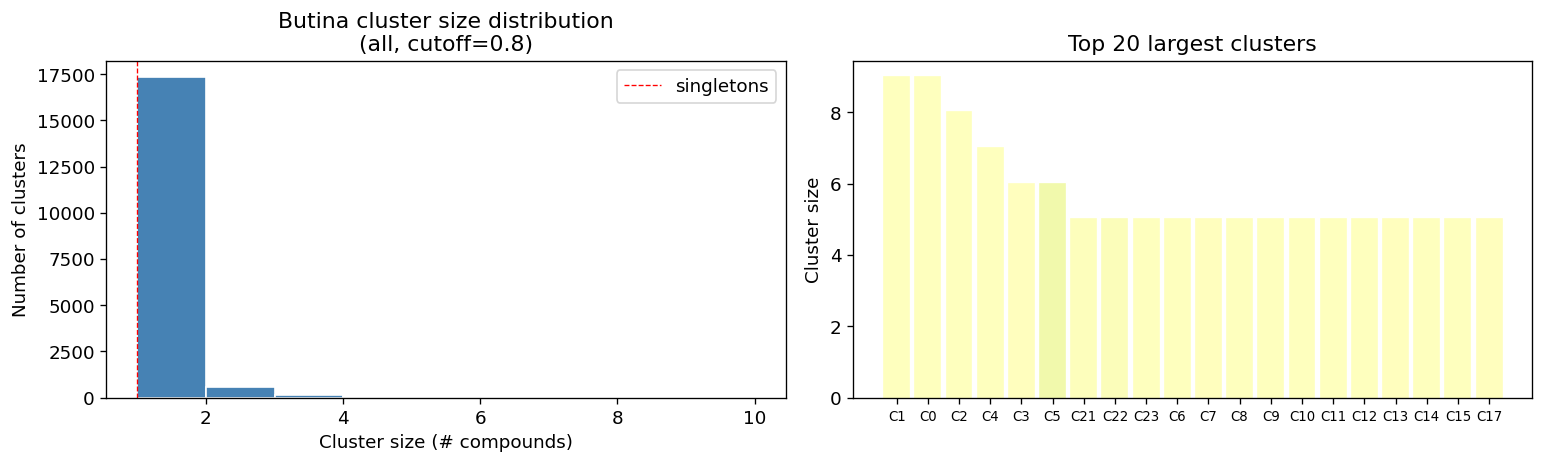

 rank  cluster_id  size  mean_selectivity  max_selectivity  pct_pgk2                                         centre_smiles
    1           1     9            0.0008           0.0028     100.0   CCc1ccc(CN(C)C(=O)CCc2nc3sc4c(c3c(=O)[nH]2)CCC4)cc1
    2           0     9            0.0000           0.0001      77.8        CCN(Cc1nc2cc(Cl)ccc2c(=O)[nH]1)C(=O)COc1ccccc1
    3           2     8            0.0001           0.0017      50.0             CN(Cc1nc2ccccc2c(=O)[nH]1)C(=O)CCc1ccccc1
    4           4     7            0.0002           0.0007      71.4             CN(Cc1nc2ccccc2c(=O)[nH]1)C(=O)COc1ccccc1
    5           3     6           -0.0001           0.0000      50.0   CCCN(Cc1nc2cc(Cl)ccc2c(=O)[nH]1)C(=O)COc1ccc(Cl)cc1
    6           5     6            0.0363           0.1444     100.0             Cc1ccc(C(=O)N(C)Cc2nc3ccsc3c(=O)[nH]2)cc1
    7          21     5            0.0043           0.0107     100.0         Cc1ccccc1NC(=O)CCc1nc2sc3c(c2c(=O)[nH]1)CCCC3
    8          2

In [15]:
# ── Cluster size distribution ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

ax = axes[0]
bins = np.arange(1, min(cluster_sizes.max() + 2, 52))
ax.hist(cluster_sizes, bins=bins, color='steelblue', edgecolor='white')
ax.set_xlabel('Cluster size (# compounds)')
ax.set_ylabel('Number of clusters')
ax.set_title(f'Butina cluster size distribution\n({label_str}, cutoff={TANIMOTO_CUTOFF})')
ax.axvline(1, color='r', ls='--', lw=0.8, label='singletons')
ax.legend()

# Top 20 largest clusters
ax = axes[1]
top20 = np.argsort(cluster_sizes)[::-1][:20]
top20_sizes = cluster_sizes[top20]
top20_labels_axis = [f"C{i}" for i in top20]
bars = ax.bar(range(len(top20)), top20_sizes, color='steelblue', edgecolor='white')
ax.set_xticks(range(len(top20)))
ax.set_xticklabels(top20_labels_axis, fontsize=8)
ax.set_ylabel('Cluster size')
ax.set_title('Top 20 largest clusters')

# Colour bars by mean selectivity of cluster
for bar, cid in zip(bars, top20):
    members = list(clusters[cid])
    mean_sel = cl_sel[members].mean()
    bar.set_color(plt.cm.RdYlGn(0.5 + mean_sel))   # green=PGK2, red=PGK1

plt.tight_layout()
plt.show()

# Summary table of top clusters
rows = []
for rank, cid in enumerate(top20):
    members = list(clusters[cid])
    m_sel  = cl_sel[members]
    cent_smi = cl_smiles[members[0]]   # cluster centre = first member
    rows.append({
        'rank'           : rank + 1,
        'cluster_id'     : cid,
        'size'           : len(members),
        'mean_selectivity': round(float(m_sel.mean()), 4),
        'max_selectivity' : round(float(m_sel.max()), 4),
        'pct_pgk2'       : round(100 * (cl_labels[members] == 'PGK2-selective').mean(), 1),
        'centre_smiles'  : cent_smi,
    })

df_clusters = pd.DataFrame(rows)
print(df_clusters.to_string(index=False))

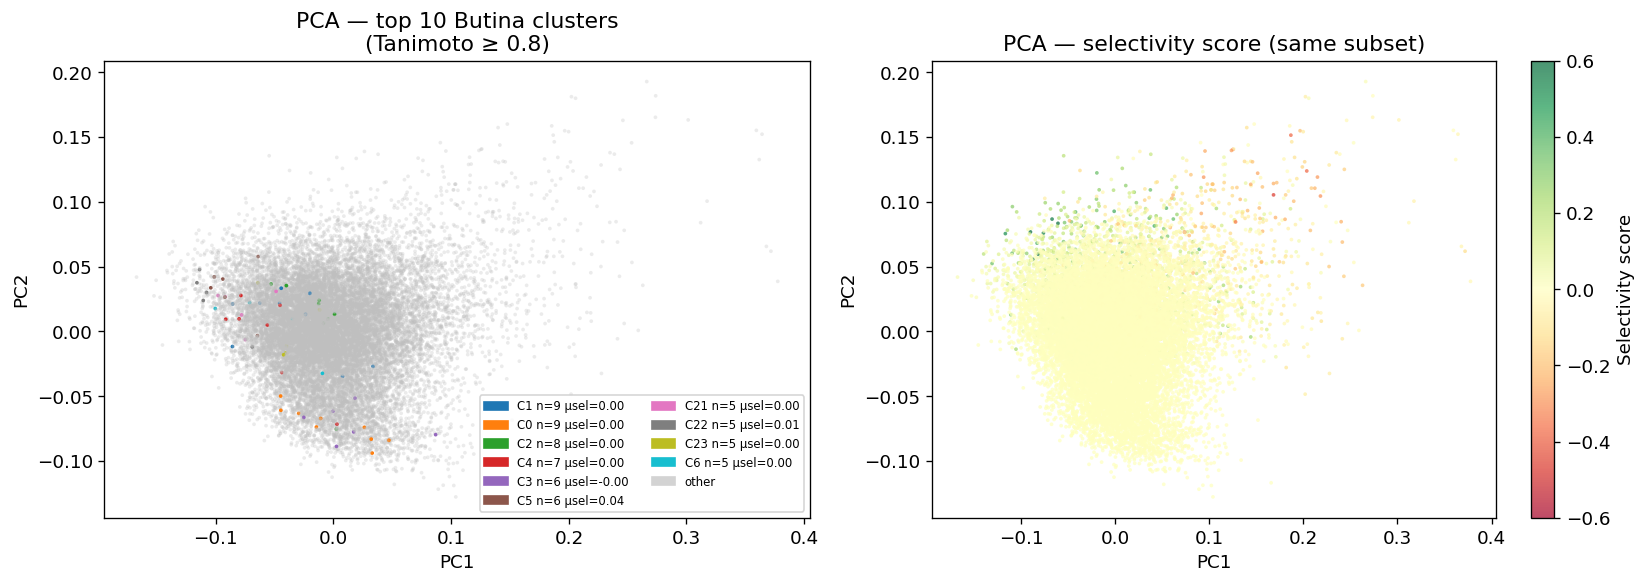

In [16]:
# ── PCA coloured by cluster identity (top N clusters highlighted) ─────────────
TOP_CLUSTERS_SHOW = 10   # highlight this many largest clusters; rest = grey

# Recompute PCA coords for the clustering subset (may differ from full-data PCA)
Z_pca_cl = PCA(n_components=2).fit_transform(metric_emb[cl_idx])

# Build a colour per point
top_cluster_ids = set(np.argsort(cluster_sizes)[::-1][:TOP_CLUSTERS_SHOW].tolist())
cmap_tab = plt.cm.get_cmap('tab10', TOP_CLUSTERS_SHOW)
cluster_rank = {cid: rank for rank, cid in enumerate(np.argsort(cluster_sizes)[::-1][:TOP_CLUSTERS_SHOW])}

point_colors = []
for cid in cluster_id:
    if cid in top_cluster_ids:
        point_colors.append(cmap_tab(cluster_rank[cid]))
    else:
        point_colors.append((0.75, 0.75, 0.75, 0.3))   # grey, transparent

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: PCA coloured by cluster
ax = axes[0]
ax.scatter(Z_pca_cl[:, 0], Z_pca_cl[:, 1],
           c=point_colors, s=5, linewidths=0)

# Legend patches for top clusters
import matplotlib.patches as mpatches
patches = []
for rank, cid in enumerate(np.argsort(cluster_sizes)[::-1][:TOP_CLUSTERS_SHOW]):
    n = cluster_sizes[cid]
    m_sel = cl_sel[list(clusters[cid])].mean()
    patches.append(mpatches.Patch(color=cmap_tab(rank),
                                  label=f'C{cid} n={n} μsel={m_sel:.2f}'))
patches.append(mpatches.Patch(color='lightgrey', label='other'))
ax.legend(handles=patches, fontsize=7, loc='best', ncol=2)
ax.set_title(f'PCA — top {TOP_CLUSTERS_SHOW} Butina clusters\n(Tanimoto ≥ {TANIMOTO_CUTOFF})')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')

# Right: selectivity score, same subset
ax = axes[1]
sc = ax.scatter(Z_pca_cl[:, 0], Z_pca_cl[:, 1],
                c=cl_sel, cmap='RdYlGn', vmin=-0.6, vmax=0.6,
                s=5, linewidths=0, alpha=0.7)
plt.colorbar(sc, ax=ax, label='Selectivity score')
ax.set_title('PCA — selectivity score (same subset)')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()

In [17]:
# ── Export cluster assignments ────────────────────────────────────────────────
df_cl_export = pd.DataFrame({
    'smiles'            : cl_smiles,
    'selectivity'       : cl_sel,
    'label'             : cl_labels,
    'cluster_id'        : cluster_id,
    'cluster_size'      : [cluster_sizes[cid] for cid in cluster_id],
    'is_cluster_centre' : [clusters[cid][0] == i for i, cid in enumerate(cluster_id)],
})

# Annotate cluster mean selectivity
cl_mean_sel = {cid: cl_sel[list(clusters[cid])].mean() for cid in range(len(clusters))}
df_cl_export['cluster_mean_selectivity'] = df_cl_export['cluster_id'].map(cl_mean_sel)

export_cl_path = Path(META_CSV).parent / f"butina_clusters_{TANIMOTO_CUTOFF}_{label_str}.csv"
df_cl_export.to_csv(export_cl_path, index=False)
print(f"✓ Saved cluster assignments → {export_cl_path}")
df_cl_export.head(10)

✓ Saved cluster assignments → data\enamine\screening_v1\butina_clusters_0.8_all.csv


,smiles,selectivity,label,cluster_id,cluster_size,is_cluster_centre,cluster_mean_selectivity
0,COc1ccc(Nc2ncnc3sccc23)c(OC)c1,0.601553,PGK2-selective,610,2,True,0.262307
1,COc1ccc(NC(C)=O)cc1Nc1ncnc2sc(C)c(C)c12,0.615394,PGK2-selective,18102,1,True,0.615394
2,CSC1(C(=O)NC2CCN(c3ncccn3)CC2)CCC1,0.515338,PGK2-selective,18101,1,True,0.515338
3,Cc1cc(C(C)Nc2ncnc3ccncc23)c(C)s1,0.544776,PGK2-selective,18100,1,True,0.544776
4,CSc1cc(C(=O)Nc2cnccn2)ccc1F,0.649323,PGK2-selective,18099,1,True,0.649323
5,CNC(=O)C1CCCN1C(=O)CNc1ncnc2sc(C)c(C)c12,0.456956,PGK2-selective,18098,1,True,0.456956
6,O=C(Nc1cccnc1)c1cnc2sccn2c1=O,0.556906,PGK2-selective,18097,1,True,0.556906
7,O=C(NCc1csc(Br)c1)c1cnccn1,0.474267,PGK2-selective,18096,1,True,0.474267
8,Cc1nc(CC(=O)Nc2ncnc3[nH]c(C)c(C)c23)cs1,0.558469,PGK2-selective,18095,1,True,0.558469
9,Cc1sc2ncnc(NCCC(=O)N3CCOCC3)c2c1C,0.420938,PGK2-selective,18094,1,True,0.420938


## 7 · PGK2 Selectivity Space Analysis

Combine everything: highlight the PGK2-selective cluster on the t-SNE map, analyse scaffold diversity (Murcko), and compare metric-space density between selective and non-selective regions.

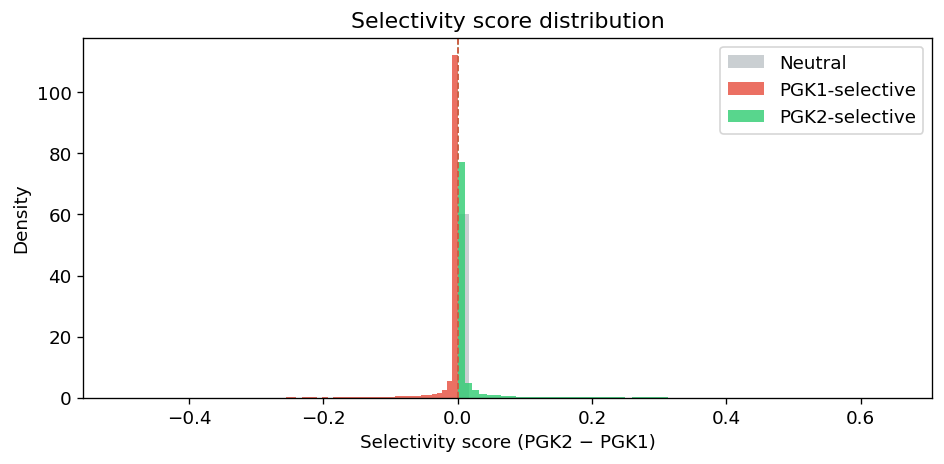

In [19]:
# ── Selectivity score distribution ───────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(selectivity[labels == 'Neutral'],       bins=60, color='#bdc3c7', label='Neutral',       alpha=0.8, density=True)
ax.hist(selectivity[labels == 'PGK1-selective'],bins=60, color='#e74c3c', label='PGK1-selective', alpha=0.8, density=True)
ax.hist(selectivity[labels == 'PGK2-selective'],bins=60, color='#2ecc71', label='PGK2-selective', alpha=0.8, density=True)
ax.axvline(THRESH_PGK2, color='#2ecc71', ls='--', lw=1)
ax.axvline(THRESH_PGK1, color='#e74c3c', ls='--', lw=1)
ax.set_xlabel('Selectivity score (PGK2 − PGK1)')
ax.set_ylabel('Density')
ax.set_title('Selectivity score distribution')
ax.legend()
plt.tight_layout()
plt.show()

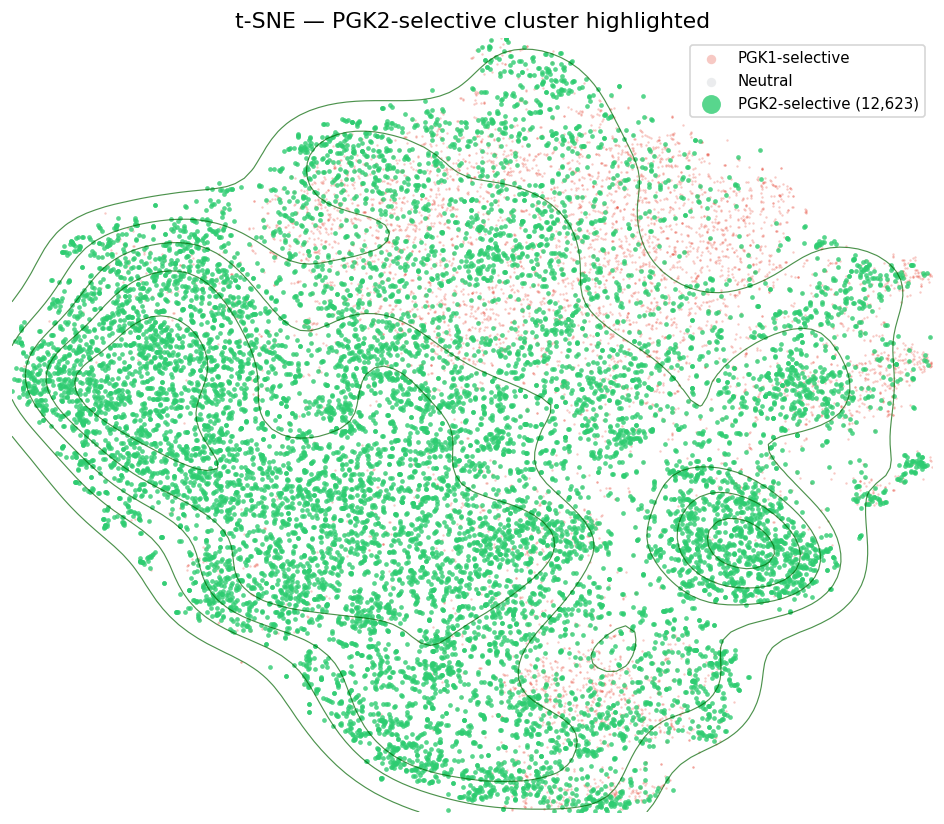

In [20]:
# ── t-SNE: highlight PGK2 selectivity cluster with density overlay ────────────
if 'Z_tsne' not in dir():
    print("Run the t-SNE cell above first.")
else:
    from scipy.stats import gaussian_kde

    fig, ax = plt.subplots(figsize=(8, 7))

    # Background (neutral + PGK1)
    for lab, col in [('PGK1-selective', '#e74c3c'), ('Neutral', '#bdc3c7')]:
        mask = labels_sub == lab
        ax.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1],
                   c=col, s=2, alpha=0.3, linewidths=0, label=lab)

    # PGK2-selective on top
    mask_pgk2 = labels_sub == 'PGK2-selective'
    ax.scatter(Z_tsne[mask_pgk2, 0], Z_tsne[mask_pgk2, 1],
               c='#2ecc71', s=8, alpha=0.8, linewidths=0, label=f'PGK2-selective ({mask_pgk2.sum():,})')

    # KDE contour over PGK2 region
    if mask_pgk2.sum() > 20:
        xy = Z_tsne[mask_pgk2].T
        kde = gaussian_kde(xy)
        xmin, xmax = Z_tsne[:, 0].min(), Z_tsne[:, 0].max()
        ymin, ymax = Z_tsne[:, 1].min(), Z_tsne[:, 1].max()
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax.contour(xx, yy, zz, levels=5, colors='darkgreen', linewidths=0.7, alpha=0.7)

    ax.set_title('t-SNE — PGK2-selective cluster highlighted')
    ax.axis('off')
    ax.legend(markerscale=4, fontsize=9, loc='upper right')
    plt.tight_layout()
    plt.show()

Top 2000 PGK2-selective compounds:
  Unique Murcko scaffolds: 1613
  Scaffold diversity ratio: 0.806  (higher = more diverse)

Top 10 most common scaffolds:
   34x  O=S(=O)(Nc1ccccc1)c1ccccc1
   30x  c1ccc(CNc2ncnc3sccc23)cc1
   18x  c1ccc(Nc2ncnc3sccc23)cc1
   10x  O=c1[nH]c(CNCc2ccccc2)nc2ccsc12
    9x  c1ncc2ccsc2n1
    7x  O=C(Nc1ccccc1)c1cncs1
    6x  O=C(NCc1nc2ccsc2c(=O)[nH]1)c1ccccc1
    6x  c1ccc2ncncc2c1
    6x  O=c1[nH]c(-c2ccccc2)nc2ccsc12
    6x  c1ccc(Nc2nc(-c3ccccc3)cs2)cc1


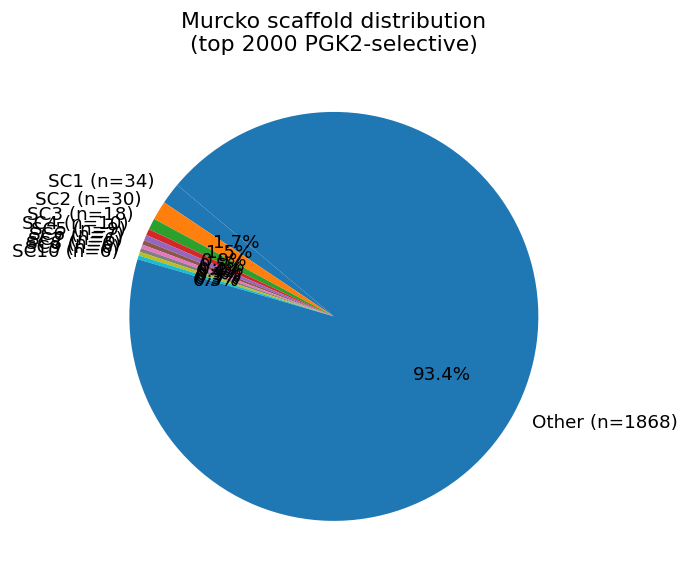

In [23]:
# ── Murcko scaffold diversity of PGK2-selective compounds ────────────────────
TOP_N_SCAFFOLDS = 2000   # analyse this many top PGK2-selective compounds

top_idx = np.argsort(selectivity)[::-1][:TOP_N_SCAFFOLDS]
top_smi = [smiles[i] for i in top_idx]

def get_murcko_scaffold(smi):
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return None
    try:
        return Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol))
    except Exception:
        return None

scaffolds = [get_murcko_scaffold(s) for s in top_smi]
scaffolds = [s for s in scaffolds if s]

scaffold_counts = pd.Series(scaffolds).value_counts()
n_unique_scaffolds = len(scaffold_counts)

print(f"Top {TOP_N_SCAFFOLDS} PGK2-selective compounds:")
print(f"  Unique Murcko scaffolds: {n_unique_scaffolds}")
print(f"  Scaffold diversity ratio: {n_unique_scaffolds / len(scaffolds):.3f}  (higher = more diverse)")
print(f"\nTop 10 most common scaffolds:")
for smi_sc, count in scaffold_counts.head(10).items():
    print(f"  {count:3d}x  {smi_sc[:80]}")

# Pie chart of scaffold distribution
fig, ax = plt.subplots(figsize=(7, 5))
top_scaffolds = scaffold_counts.head(10)
other_count  = scaffold_counts.iloc[10:].sum()
pie_data  = list(top_scaffolds.values) + ([other_count] if other_count > 0 else [])
pie_labels = [f"SC{i+1} (n={v})" for i, v in enumerate(top_scaffolds.values)]
if other_count > 0:
    pie_labels.append(f"Other (n={other_count})")
ax.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=140)
ax.set_title(f'Murcko scaffold distribution\n(top {TOP_N_SCAFFOLDS} PGK2-selective)')
plt.tight_layout()
plt.show()

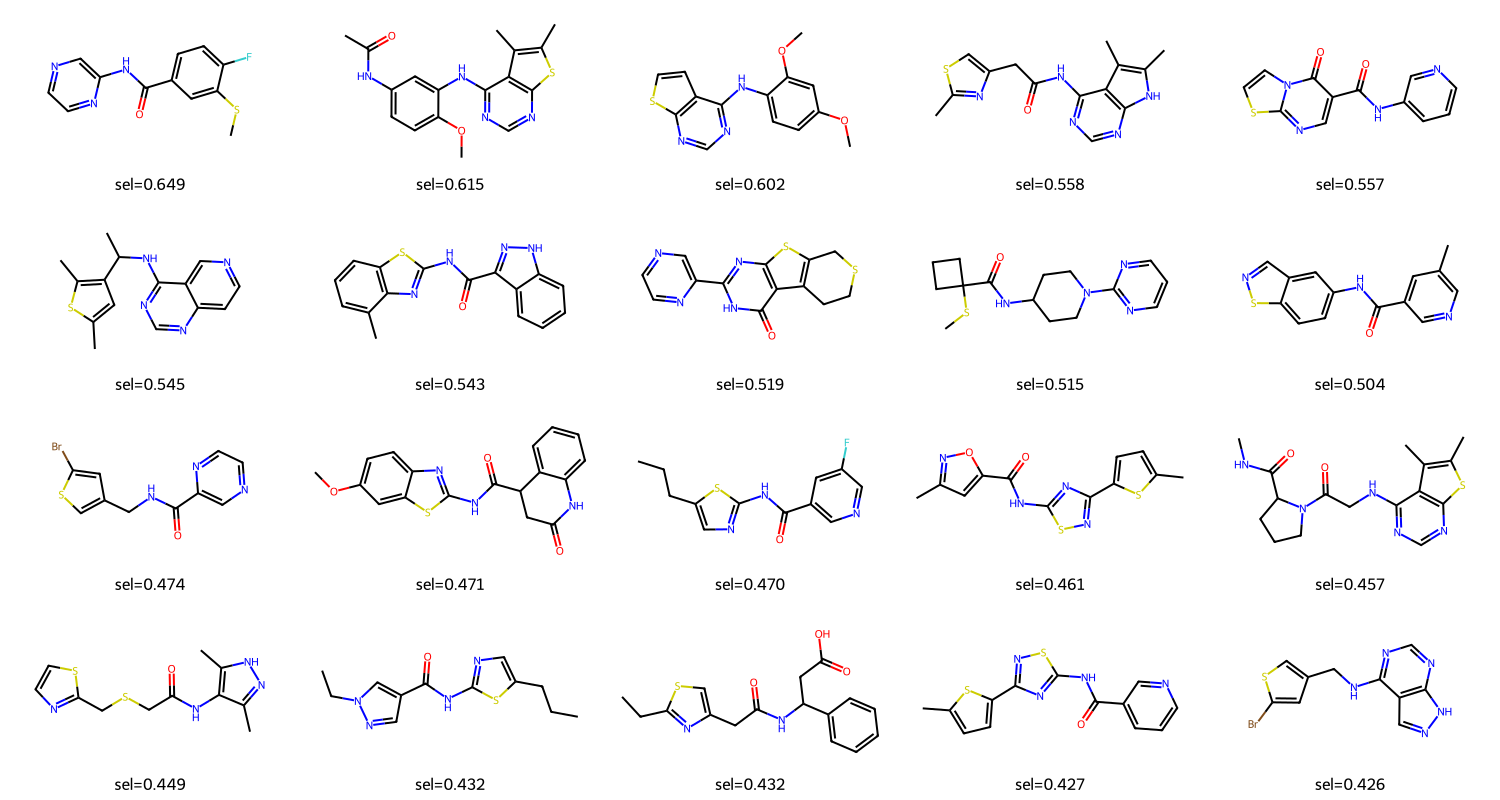

In [24]:
# ── Draw top PGK2-selective hits ─────────────────────────────────────────────
N_DRAW = 20

top_draw_idx = np.argsort(selectivity)[::-1][:N_DRAW]
top_draw_smi = [smiles[i] for i in top_draw_idx]
top_draw_sel = selectivity[top_draw_idx]

mols = []
legends = []
for smi, sel in zip(top_draw_smi, top_draw_sel):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        mols.append(mol)
        legends.append(f"sel={sel:.3f}")

img = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    subImgSize=(300, 200),
    legends=legends,
)
display(img)

In [25]:
# ── Export enriched table for external tools (e.g., Spotfire, Datamol) ────────
export_path = Path(META_CSV).parent / "projections_analysis.csv"

df_export = df.copy()
df_export['pc1'] = Z_pca[:, 0]
df_export['pc2'] = Z_pca[:, 1]
df_export['label'] = labels

# t-SNE coords — only for sub-sampled rows
tsne_pc1 = np.full(len(df_export), np.nan)
tsne_pc2 = np.full(len(df_export), np.nan)
tsne_pc1[idx_tsne] = Z_tsne[:, 0]
tsne_pc2[idx_tsne] = Z_tsne[:, 1]
df_export['tsne1'] = tsne_pc1
df_export['tsne2'] = tsne_pc2

df_export.to_csv(export_path, index=True)
print(f"✓ Saved enriched analysis table → {export_path}")
df_export.head()

✓ Saved enriched analysis table → data\enamine\screening_v1\projections_analysis.csv


,smiles,p_bind_pgk1,p_bind_pgk2,selectivity,pc1,pc2,label,tsne1,tsne2
0,COc1ccc(Nc2ncnc3sccc23)c(OC)c1,0.035245,0.636798,0.601553,-0.089931,0.076785,PGK2-selective,-60.453575,12.969496
1,COc1ccc(NC(C)=O)cc1Nc1ncnc2sc(C)c(C)c12,0.061242,0.676635,0.615394,-0.081763,0.059697,PGK2-selective,-59.225178,13.493329
2,CSC1(C(=O)NC2CCN(c3ncccn3)CC2)CCC1,0.062769,0.578107,0.515338,-0.116591,0.075475,PGK2-selective,-59.692734,8.356773
3,Cc1cc(C(C)Nc2ncnc3ccncc23)c(C)s1,0.085639,0.630416,0.544776,-0.076174,0.075902,PGK2-selective,-58.435974,12.256168
4,CSc1cc(C(=O)Nc2cnccn2)ccc1F,0.193452,0.842775,0.649323,-0.060684,0.083408,PGK2-selective,-56.633244,20.277990
